In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sps

In [2]:
def wrap_function(phi):
    """Computes the wrap function elementwise for the input array.
    """

    return ( (phi + np.pi) % (2*np.pi) ) - np.pi

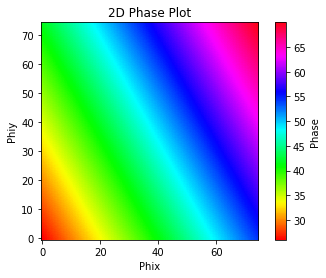

In [3]:
# create phase date for x and y direction
M = 75
N = 75
phix = np.linspace(0, 9*np.pi, M) + (3*np.pi) + 3
phiy = np.linspace(0, 5*np.pi, N) + (4*np.pi) + 1
X, Y = np.meshgrid(phix, phiy)
phi = X + Y

# Create the phase plot (source Chat GPT for the below code)
plt.imshow(phi, cmap='hsv', origin='lower')
plt.colorbar(label='Phase')
plt.xlabel('Phix')
plt.ylabel('Phiy')
plt.title('2D Phase Plot')
plt.show()

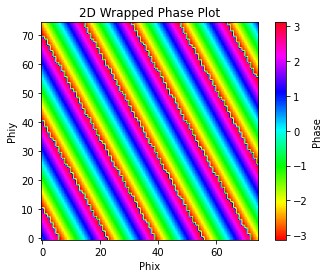

In [4]:
psi = wrap_function(phi)
plt.imshow(psi, cmap='hsv', origin='lower')
plt.colorbar(label='Phase')
plt.xlabel('Phix')
plt.ylabel('Phiy')
plt.title('2D Wrapped Phase Plot')
plt.show()


In [5]:
def build_1d_first_order_grad(N: int, 
    boundary: str = "periodic",
):
    """Constructs a SciPy sparse matrix that extracts the (1D) discrete gradient of an input signal.
    Boundary parameter specifies how to handle the boundary conditions.
    """
    
    assert boundary in ["none", "periodic", "zero"], "Invalid boundary parameter."
    
    d_mat = sps.eye(N)
    d_mat.setdiag(-1,k=-1)
    #d_mat = sps.csc_matrix(d_mat)
    d_mat = d_mat.tolil()
    
    if boundary == "periodic":
        d_mat[0,-1] = -1
    elif boundary == "zero":
        pass
    elif boundary == "none":
        d_mat = d_mat[1:,:]
    else:
        pass
    
    return d_mat

In [6]:
def build_2d_first_order_grad(M: int, N: int, boundary = "zero",
):
    """Constructs a SciPy sparse matrix that extracts the discrete gradient of an input image.
    Assumes periodic BCs. Input image should have original dimension (M,N), must be flattened
    to compute matrix-vector product. First set is horizontal gradient, second is vertical.
    """

    # Construct our differencing matrices
    d_mat_horiz = build_1d_first_order_grad(N, boundary=boundary)
    d_mat_vert = build_1d_first_order_grad(M, boundary=boundary)
    
    # Build the combined matrix
    eye_vert = sps.eye(M)
    d_mat_one = sps.kron(eye_vert, d_mat_horiz)
    
    eye_horiz = sps.eye(N)
    d_mat_two = sps.kron(d_mat_vert, eye_horiz)

    # full_diff_mat = sps.vstack([d_mat_one, d_mat_two])
    
    return d_mat_one, d_mat_two


In [7]:
Fx, Fy = build_2d_first_order_grad(M,N, boundary="none")


In [8]:
def upsampling_matrix(n):
    # Constructing the upsampling matrix
    P = np.zeros((n+1, n))
    P[1:, :] = np.eye(n)
    return P

In [9]:
def solve_D2_MLE_2D(psi, Fx, Fy, weights=None):
    psi_flatten = psi.flatten()
    #for x direction

    # Set initial weights
    #might have to adjust this code if we are not looking at N by N image
    if weights is None:
        weights = np.ones(Fx.shape[0])
    else:
        assert len(weights) == len(psi), "psi and weight vector must have same length!"
    
    P = upsampling_matrix(len(psi_flatten) - 1)
    
    
    phi1 = np.zeros(len(psi_flatten))
    phi1[0] = psi_flatten[0]
    
   
    # rhs vector
    rhs = P.T @ Fx.T @ np.diag(weights) @ ( wrap_function(Fx @ psi_flatten) - (Fx @ phi1) ) + P.T @ Fy.T @ np.diag(weights) @ ( wrap_function(Fy @ psi_flatten) - (Fy @ phi1) )

    # Q matrix
    Q = P.T @ Fx.T @ np.diag(weights) @ Fx @ P  + P.T @ Fy.T @ np.diag(weights) @ Fy @ P

    # Solve system for answer
    phi2 = np.linalg.solve(Q, rhs)

    # Append first entry
    reconstructed_phi = np.zeros(len(psi_flatten))
    reconstructed_phi[1:] = phi2
    reconstructed_phi[0] = psi_flatten[0]

    return reconstructed_phi

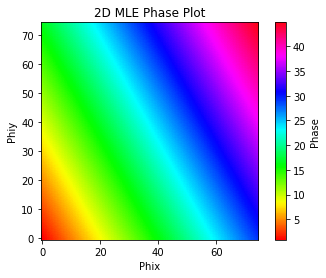

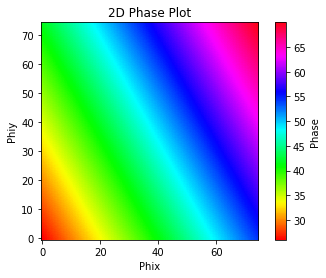

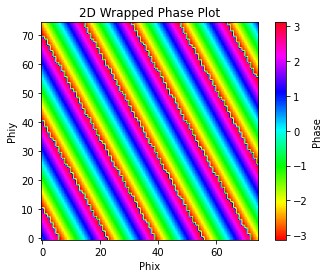

In [10]:
reconstructed_phi = solve_D2_MLE_2D(psi, Fx, Fy)
reconstructed_phi = reconstructed_phi.reshape(M,N)
plt.imshow(reconstructed_phi, cmap='hsv', origin='lower')
plt.colorbar(label='Phase')
plt.xlabel('Phix')
plt.ylabel('Phiy')
plt.title('2D MLE Phase Plot')
plt.show()

plt.imshow(phi, cmap='hsv', origin='lower')
plt.colorbar(label='Phase')
plt.xlabel('Phix')
plt.ylabel('Phiy')
plt.title('2D Phase Plot')
plt.show()


plt.imshow(psi, cmap='hsv', origin='lower')
plt.colorbar(label='Phase')
plt.xlabel('Phix')
plt.ylabel('Phiy')
plt.title('2D Wrapped Phase Plot')
plt.show()

# notice the same phase plot basically exceot subtract about 25 from phase

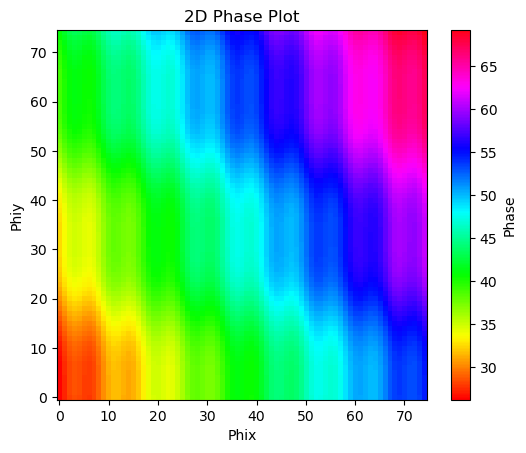

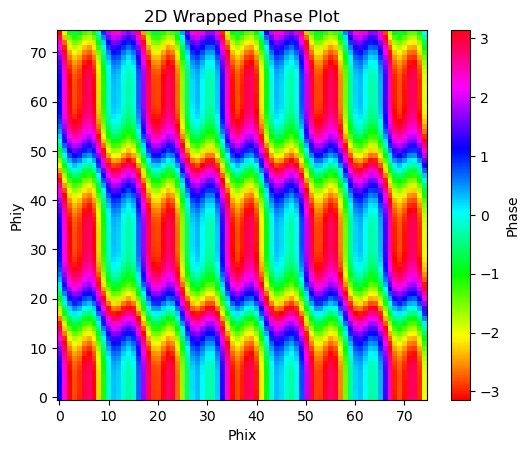

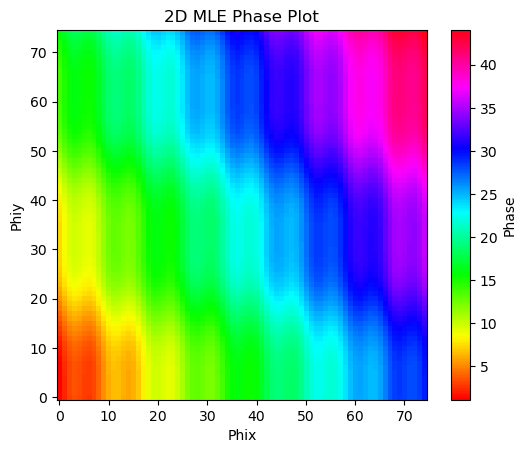

In [159]:
# now try sinudial with trend
# create phase date for x and y direction
# works
phix = np.linspace(0, 9*np.pi, M) + (3*np.pi) + 3
phiy = np.linspace(0, 5*np.pi, N) + (4*np.pi) + 1
X, Y = np.meshgrid(phix, phiy)
trend = np.cos(Y) + np.sin(2*X)
phi = X + Y + trend

# Create the phase plot (source Chat GPT for the below code)
plt.imshow(phi, cmap='hsv', origin='lower')
plt.colorbar(label='Phase')
plt.xlabel('Phix')
plt.ylabel('Phiy')
plt.title('2D Phase Plot')
plt.show()

# wrapped numbers
psi = wrap_function(phi)

plt.imshow(psi, cmap='hsv', origin='lower')
plt.colorbar(label='Phase')
plt.xlabel('Phix')
plt.ylabel('Phiy')
plt.title('2D Wrapped Phase Plot')
plt.show()

# unwrapped
reconstructed_phi = solve_D2_MLE_2D(psi, Fx, Fy)
reconstructed_phi = reconstructed_phi.reshape(M,N)
plt.imshow(reconstructed_phi, cmap='hsv', origin='lower')
plt.colorbar(label='Phase')
plt.xlabel('Phix')
plt.ylabel('Phiy')
plt.title('2D MLE Phase Plot')
plt.show()








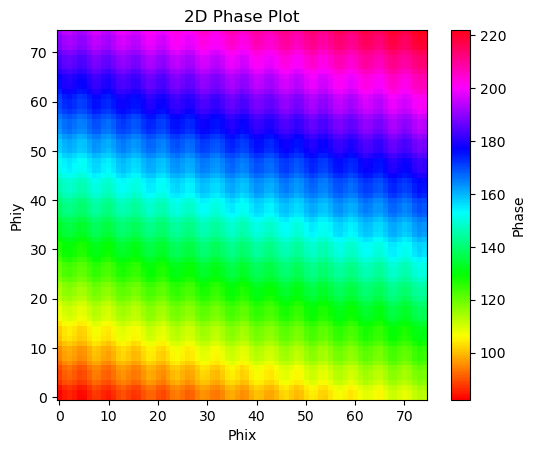

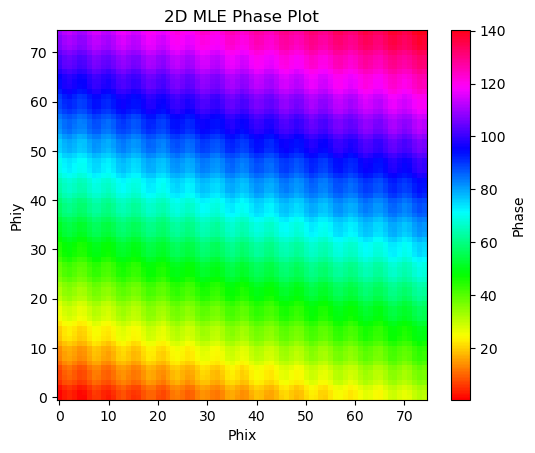

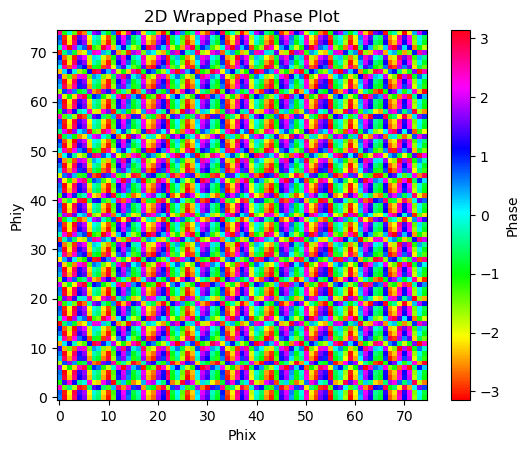

In [166]:
# now try with big sinudial with trend
# create phase date for x and y direction
phix = np.linspace(0, 9*np.pi, M) + 7*(3*np.pi) + 3
phiy = 7* np.linspace(0, 5*np.pi, N) + (4*np.pi) + 1
X, Y = np.meshgrid(phix, phiy)
trend = 2*np.sin(3*X) + np.cos(Y)
phi = X + Y + trend

# Create the phase plot (source Chat GPT for the below code)
plt.imshow(phi, cmap='hsv', origin='lower')
plt.colorbar(label='Phase')
plt.xlabel('Phix')
plt.ylabel('Phiy')
plt.title('2D Phase Plot')
plt.show()

psi = wrap_function(phi)

# unwrapped
reconstructed_phi = solve_D2_MLE_2D(psi, Fx, Fy)
reconstructed_phi = reconstructed_phi.reshape(M,N)
plt.imshow(reconstructed_phi, cmap='hsv', origin='lower')
plt.colorbar(label='Phase')
plt.xlabel('Phix')
plt.ylabel('Phiy')
plt.title('2D MLE Phase Plot')
plt.show()


# wrapped numbers
plt.imshow(psi, cmap='hsv', origin='lower')
plt.colorbar(label='Phase')
plt.xlabel('Phix')
plt.ylabel('Phiy')
plt.title('2D Wrapped Phase Plot')
plt.show()



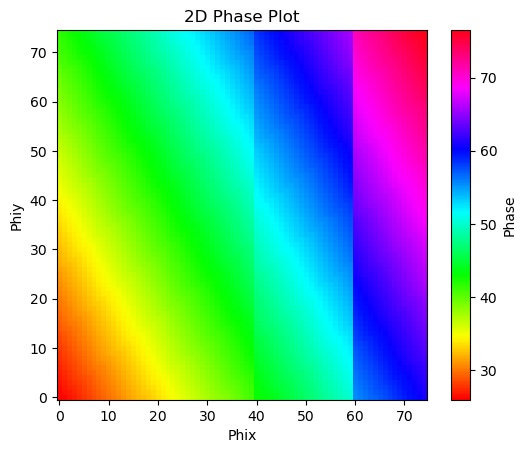

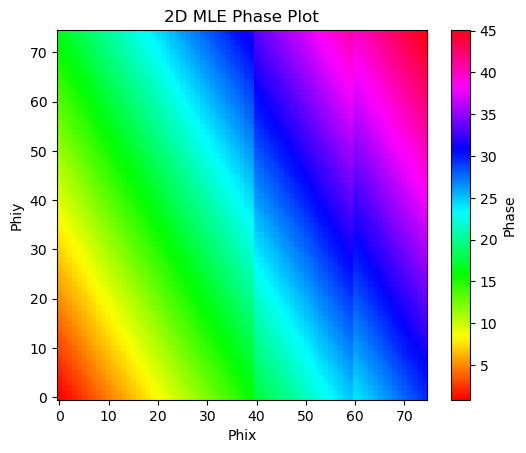

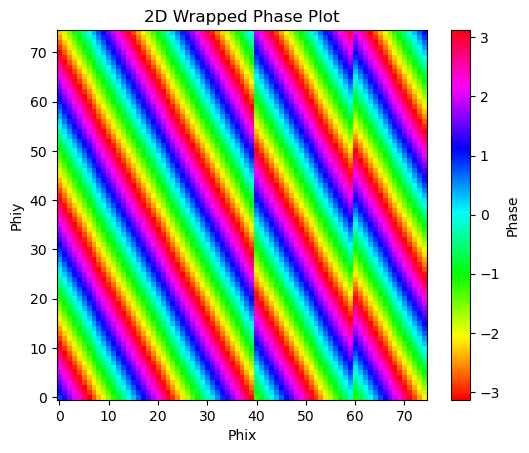

In [164]:
# Now try piecewise signal
# create phase date for x and y direction
phix = np.linspace(0, 9*np.pi, M) + (3*np.pi) + 3
phix[40:] += 1.5
phix[60:] += 5
phiy = np.linspace(0, 5*np.pi, N) + (4*np.pi) + 1
X, Y = np.meshgrid(phix, phiy)
phi = X + Y

# Create the phase plot (source Chat GPT for the below code)
plt.imshow(phi, cmap='hsv', origin='lower')
plt.colorbar(label='Phase')
plt.xlabel('Phix')
plt.ylabel('Phiy')
plt.title('2D Phase Plot')
plt.show()

psi = wrap_function(phi)

# unwrapped
reconstructed_phi = solve_D2_MLE_2D(psi, Fx, Fy)
reconstructed_phi = reconstructed_phi.reshape(M,N)
plt.imshow(reconstructed_phi, cmap='hsv', origin='lower')
plt.colorbar(label='Phase')
plt.xlabel('Phix')
plt.ylabel('Phiy')
plt.title('2D MLE Phase Plot')
plt.show()


# wrapped numbers
plt.imshow(psi, cmap='hsv', origin='lower')
plt.colorbar(label='Phase')
plt.xlabel('Phix')
plt.ylabel('Phiy')
plt.title('2D Wrapped Phase Plot')
plt.show()

